In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 4, 7, 9]
# branch_defs = [
#     ((0, 4, 9), 0.5, 1),
#     ((0,), 0, 0.5),
#     ((4, 9), 0.35, 0.5),
#     ((4,), 0, 0.35),
#     ((9,), 0, 0.35)
# ]
branch_defs = [((0, 4, 7, 9), 0, 1)]

# classes = list(range(10))
# branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Create the model

In [5]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs), t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/mnist_continuous_0479_nobranch"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

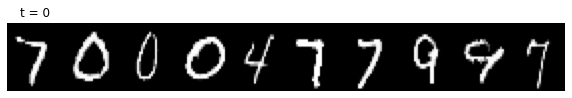

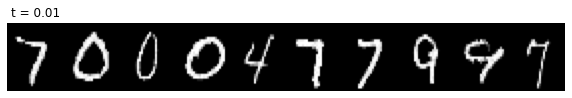

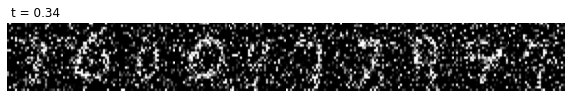

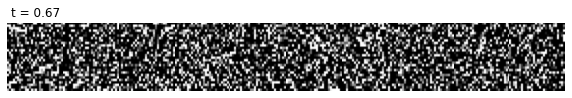

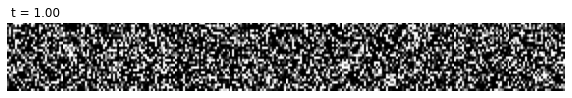

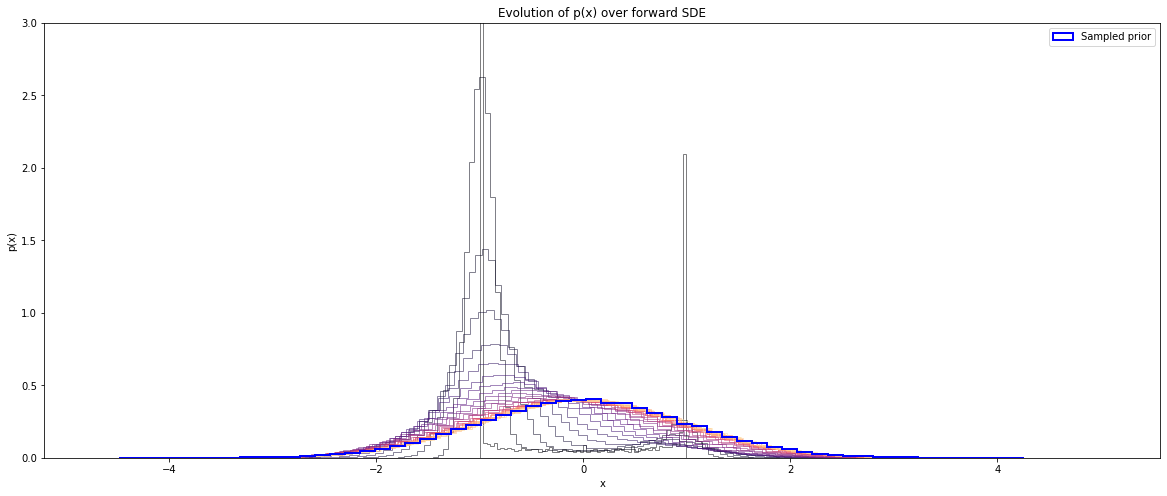

In [6]:
# Show some images after running the SDE forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.linspace(0.01, t_limit, time_steps):
    xt, score = sde.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %.2f" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

### Show generated digits

In [7]:
train_continuous_model.train_ex.run(
    "train_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 30,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_model'
INFO - train - Started run with ID "1"
Loss: 81.33: 100%|████████████████████████████████████████| 188/188 [00:08<00:00, 22.92it/s]


Epoch 1 average Loss: 237.36


Loss: 99.86: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.29it/s]


Epoch 2 average Loss: 88.27


Loss: 66.77: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.34it/s]


Epoch 3 average Loss: 72.71


Loss: 63.06: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.39it/s]


Epoch 4 average Loss: 64.39


Loss: 74.19: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.25it/s]


Epoch 5 average Loss: 60.25


Loss: 34.92: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.19it/s]


Epoch 6 average Loss: 55.21


Loss: 42.22: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.40it/s]


Epoch 7 average Loss: 52.72


Loss: 51.77: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.34it/s]


Epoch 8 average Loss: 50.81


Loss: 53.18: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.23it/s]


Epoch 9 average Loss: 48.13


Loss: 41.08: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.43it/s]


Epoch 10 average Loss: 47.11


Loss: 66.50: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.38it/s]


Epoch 11 average Loss: 46.57


Loss: 64.06: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.39it/s]


Epoch 12 average Loss: 45.16


Loss: 32.41: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.39it/s]


Epoch 13 average Loss: 44.11


Loss: 38.73: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.45it/s]


Epoch 14 average Loss: 42.46


Loss: 80.59: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.28it/s]


Epoch 15 average Loss: 43.10


Loss: 24.01: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.34it/s]


Epoch 16 average Loss: 41.66


Loss: 29.52: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.16it/s]


Epoch 17 average Loss: 39.74


Loss: 50.57: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.19it/s]


Epoch 18 average Loss: 39.93


Loss: 26.71: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.34it/s]


Epoch 19 average Loss: 39.46


Loss: 27.42: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.32it/s]


Epoch 20 average Loss: 39.43


Loss: 37.24: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.24it/s]


Epoch 21 average Loss: 38.45


Loss: 38.93: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.27it/s]


Epoch 22 average Loss: 39.08


Loss: 28.99: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.16it/s]


Epoch 23 average Loss: 38.01


Loss: 30.45: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.21it/s]


Epoch 24 average Loss: 37.39


Loss: 33.29: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.37it/s]


Epoch 25 average Loss: 36.53


Loss: 32.37: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.46it/s]


Epoch 26 average Loss: 37.21


Loss: 19.34: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.24it/s]


Epoch 27 average Loss: 36.33


Loss: 47.40: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 26.00it/s]


Epoch 28 average Loss: 36.63


Loss: 50.88: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 25.70it/s]


Epoch 29 average Loss: 36.05


Loss: 51.84: 100%|████████████████████████████████████████| 188/188 [00:07<00:00, 25.61it/s]
INFO - train - Completed after 0:03:37


Epoch 30 average Loss: 36.26


Sampling class: 0


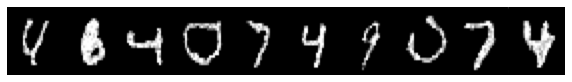

Sampling class: 4


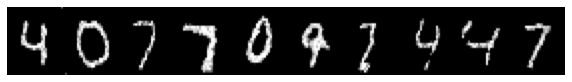

Sampling class: 7


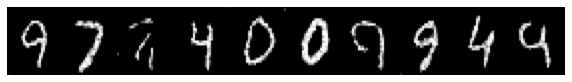

Sampling class: 9


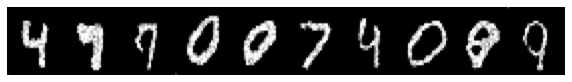

In [8]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

**Intermediate states**

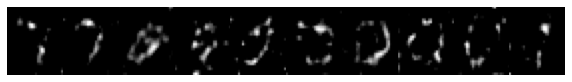

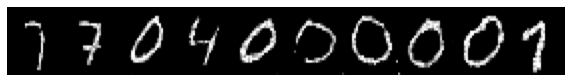

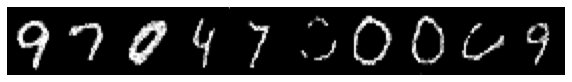

In [9]:
branch_time_4_9 = 0.35

samples_49 = generate.generate_continuous_samples(
    model, sde, 4, class_time_to_branch_tensor, sampler="pc", t_start=branch_time_4_9,
    t_limit=t_limit
).cpu().numpy()
samples_4 = generate.generate_continuous_samples(
    model, sde, 4, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time_4_9,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()
samples_9 = generate.generate_continuous_samples(
    model, sde, 9, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time_4_9,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()

smoothed_samples_49 = np.empty_like(samples_49)
for i in range(len(samples_49)):
    smoothed_samples_49[i, 0] = scipy.ndimage.gaussian_filter(samples_49[i, 0], sigma=1)
    
plot_mnist_digits(smoothed_samples_49)
plot_mnist_digits(samples_4)
plot_mnist_digits(samples_9)

**Diffusing from one class to another**

/local/55178868/ipykernel_31493/1183397087.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)


4 to 9


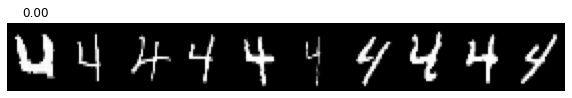

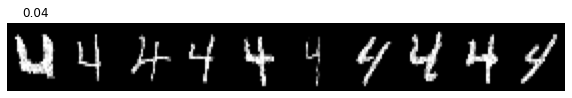

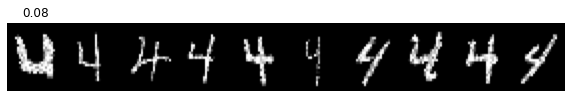

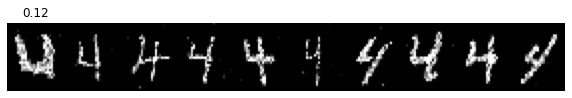

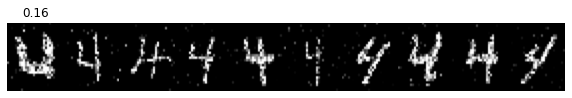

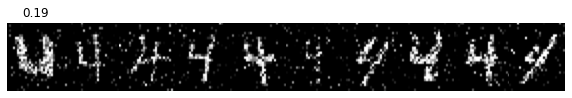

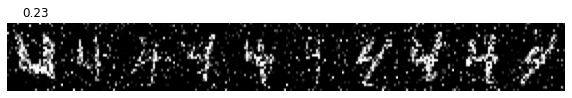

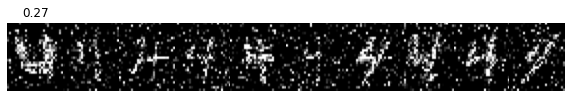

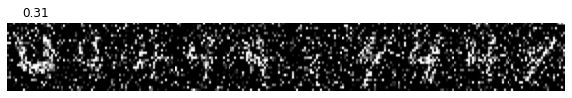

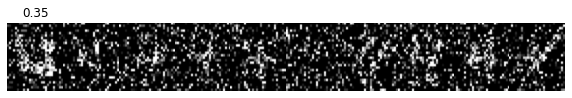

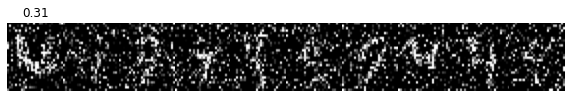

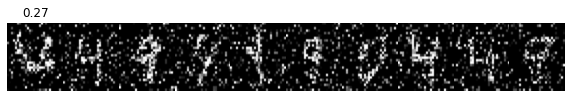

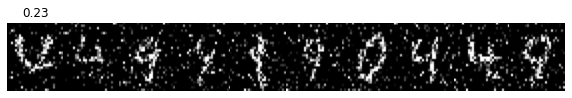

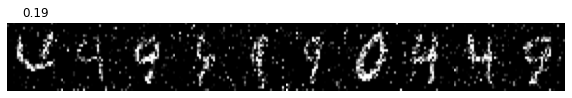

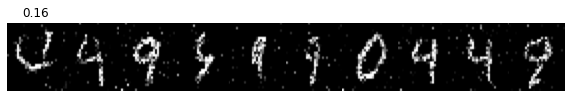

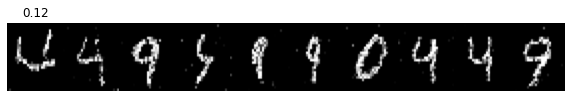

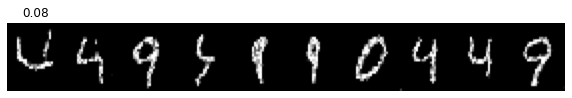

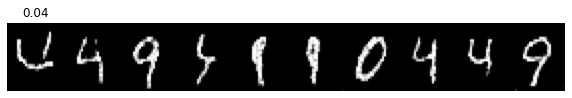

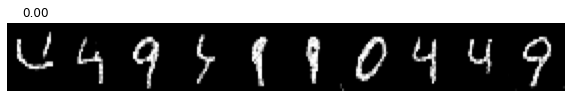

9 to 4


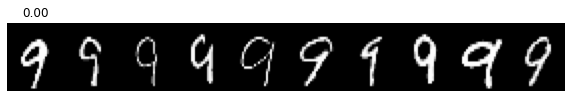

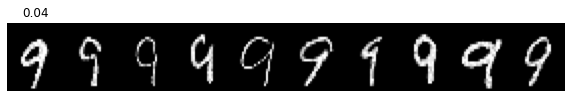

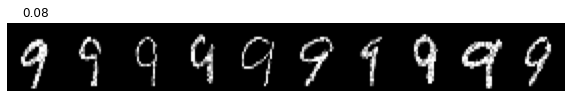

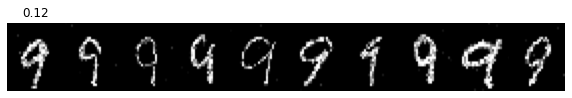

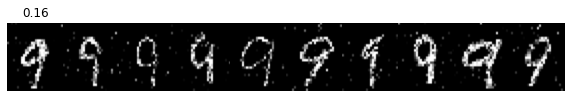

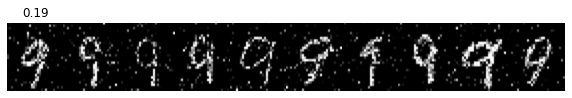

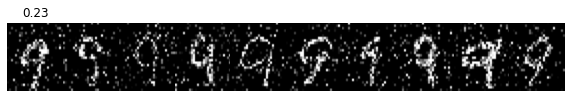

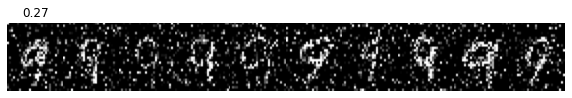

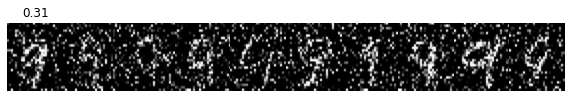

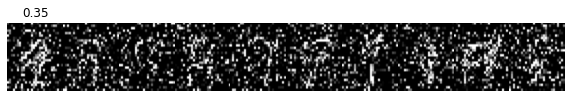

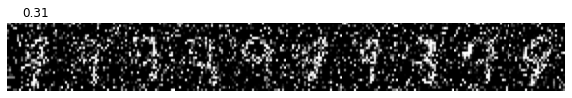

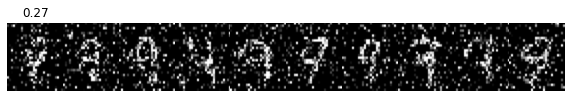

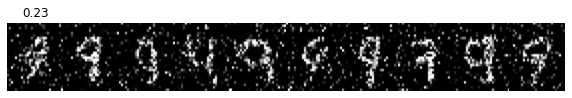

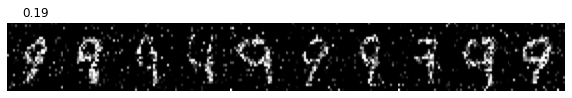

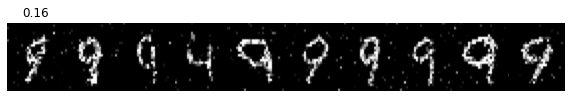

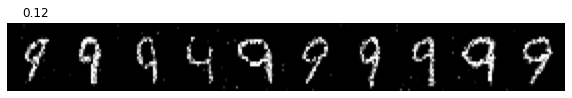

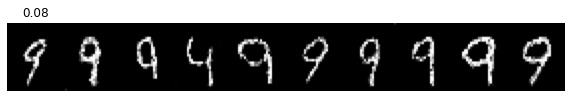

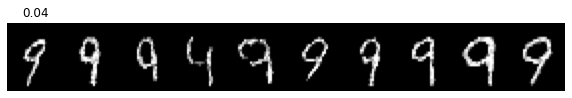

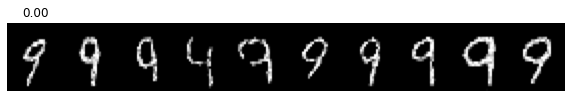

In [10]:
orig_4 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
])
orig_9 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
])

time_steps = 10
all_t = np.linspace(0, branch_time_4_9, time_steps)
forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
for t_i, t in enumerate(all_t):
    forward_4_to_9[t_i] = sde.forward(
        orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_9_to_4[t_i] = sde.forward(
        orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_4_to_9 = generate.generate_continuous_samples(
        model, sde, 9, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_4.shape[0], initial_samples=last_4_to_9,
        num_steps=50
    )
    backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
    last_9_to_4 = generate.generate_continuous_samples(
        model, sde, 4, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_9.shape[0], initial_samples=last_9_to_4,
        num_steps=50
    )
    backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
print("4 to 9")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_4_to_9[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_4_to_9[t_i], title=("%.2f" % t))

print("9 to 4")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_9_to_4[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_9_to_4[t_i], title=("%.2f" % t))